# Homework 2, *part 2*
### (60 points total)

In this part, you will build a convolutional neural network (CNN) to solve (yet another) image classification problem: the Tiny ImageNet dataset (200 classes, 100K training images, 10K validation images). Try to achieve as high accuracy as possible.

## Deliverables

* This file.
* A "checkpoint file" `"checkpoint.pth"` that contains your CNN's weights (you get them from `model.state_dict()`). Obtain it with `torch.save(..., "checkpoint.pth")`. When grading, we will load it to evaluate your accuracy.

**Should you decide to put your `"checkpoint.pth"` on Google Drive, update (edit) the following cell with the link to it:**

### [Dear TAs, I've put my "checkpoint.pth" on Google Drive, download it here](https://drive.google.com/file/d/14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ/view?usp=sharing)

## Grading

* 9 points for reproducible training code and a filled report below.
* 11 points for building a network that gets above 25% accuracy.
* 4 points for using an **interactive** (please don't reinvent the wheel with `plt.plot`) tool for viewing progress, for example Tensorboard ([with this library](https://github.com/lanpa/tensorboardX) and [an extra hack for Colab](https://stackoverflow.com/a/57791702)). In this notebook, insert screenshots of accuracy and loss plots (training and validation) over iterations/epochs/time.
* 6 points for beating each of these accuracy milestones on the private **test** set:
  * 30%
  * 34%
  * 38%
  * 42%
  * 46%
  * 50%
  
*Private test set* means that you won't be able to evaluate your model on it. Rather, after you submit code and checkpoint, we will load your model and evaluate it on that test set ourselves, reporting your accuracy in a comment to the grade.

Note that there is an important formatting requirement, see below near "`DO_TRAIN = True`".

## Restrictions

* No pretrained networks.
* Don't enlarge images (e.g. don't resize them to $224 \times 224$ or $256 \times 256$).

## Tips

* **One change at a time**: never test several new things at once (unless you are super confident). Train a model, introduce one change, train again.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation...
* Pay much attention to accuracy and loss graphs (e.g. in Tensorboard). Track failures early, stop bad experiments early.

In [1]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
AUX_DATA_ROOT

PosixPath('/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2')

The below cell puts training and validation images in `./tiny-imagenet-200/train` and `./tiny-imagenet-200/val`:

In [0]:
# Extract the dataset into the current directory
if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
    import zipfile
    with zipfile.ZipFile(AUX_DATA_ROOT/'tiny-imagenet-2020.zip', 'r') as archive:
        archive.extractall()

In [4]:
!ls

drive  sample_data  tiny-imagenet-200


**You are required** to format your notebook cells so that `Run All` on a fresh notebook:
* trains your model from scratch, if `DO_TRAIN is True`;
* loads your trained model from `"./checkpoint.pth"`, then **computes** and prints its validation accuracy, if `DO_TRAIN is False`.

In [0]:
DO_TRAIN = False
# DO_TRAIN = True

## Train the model

In [0]:
# Your code here (feel free to add cells)

In [0]:
import torch 
import torchvision
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.nn.modules import loss
from tqdm.notebook import tqdm
from datetime import datetime

In [0]:
trans = {'train': torchvision.transforms.Compose([                  
                                                       torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
                                                       torchvision.transforms.RandomPerspective(),
                                                       torchvision.transforms.RandomRotation(10),
                                                       torchvision.transforms.RandomHorizontalFlip(),
                                                       torchvision.transforms.RandomVerticalFlip(),
                                                       torchvision.transforms.ToTensor(),
                                                       torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

                                                       ]),

              'test' : torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                       torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}

In [0]:
#import the data
path = Path.cwd()/'tiny-imagenet-200'
train_data = torchvision.datasets.ImageFolder(path/'train',transform=trans['train'])
val_data = torchvision.datasets.ImageFolder(path/'val', transform = trans['test'])

In [10]:
bs = 300
train_dataloader = torch.utils.data.DataLoader(train_data,
                                         batch_size = bs,
                                         num_workers = 4,
                                         shuffle=True,
                                         pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                         batch_size = bs,
                                         num_workers = 4,
                                         shuffle=False,
                                         pin_memory=True)

del train_data, val_data
print(f"Train/val dataloaders have {len(train_dataloader)} and {len(val_dataloader)} batches")

Train/val dataloaders have 334 and 34 batches


In [0]:
def train(epoches, model, criterion, optimizer, device, exp_name, train_dataloader, val_dataloader, scheduler=None):
  
  best_acc = 0 
  writer = SummaryWriter(f'./logs/{exp_name}')
  counter = 0
  for epoch in range(epoches):
    
    ### training part 
    model.train()
    correct = 0
    for batch, labels in tqdm(train_dataloader): 
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      output = model(batch)
      loss = criterion(output, labels)   
      loss.backward()
      optimizer.step()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(labels.view_as(pred)).sum().item()
      counter += 1
      writer.add_scalar("train loss", loss.item(), global_step=counter)
    # print('Train Loss: ', loss.item())
    # print('Accuracy: ', 100.0 * correct / len(train_dataloader.dataset))
    writer.add_scalar("train_accuracy_plot", 100.0 * correct / len(train_dataloader.dataset),global_step=epoch,)
    
    #### test part 
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for batch, labels in val_dataloader: 
        batch, labels = batch.to(device), labels.to(device)
        output = model(batch)
        test_loss += criterion(output, labels).item()   
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

    val_acc = 100*correct/len(val_dataloader.dataset)
    test_loss = test_loss/len(val_dataloader.dataset)
    writer.add_scalar('test_loss',test_loss, global_step=epoch)
    writer.add_scalar('Val_accuracy',val_acc, global_step=epoch)
    
    if scheduler:
      scheduler.step()

    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(),AUX_DATA_ROOT/f'checkpoints/{exp_name}.pth')

      
def accuracy(pred, labels):
  pred = pred.argmax(dim=1, keepdim=True)
  out  = torch.sum(pred == labels)/len(labels)
  return out
  
      

## Densenet161 traning proccess plots

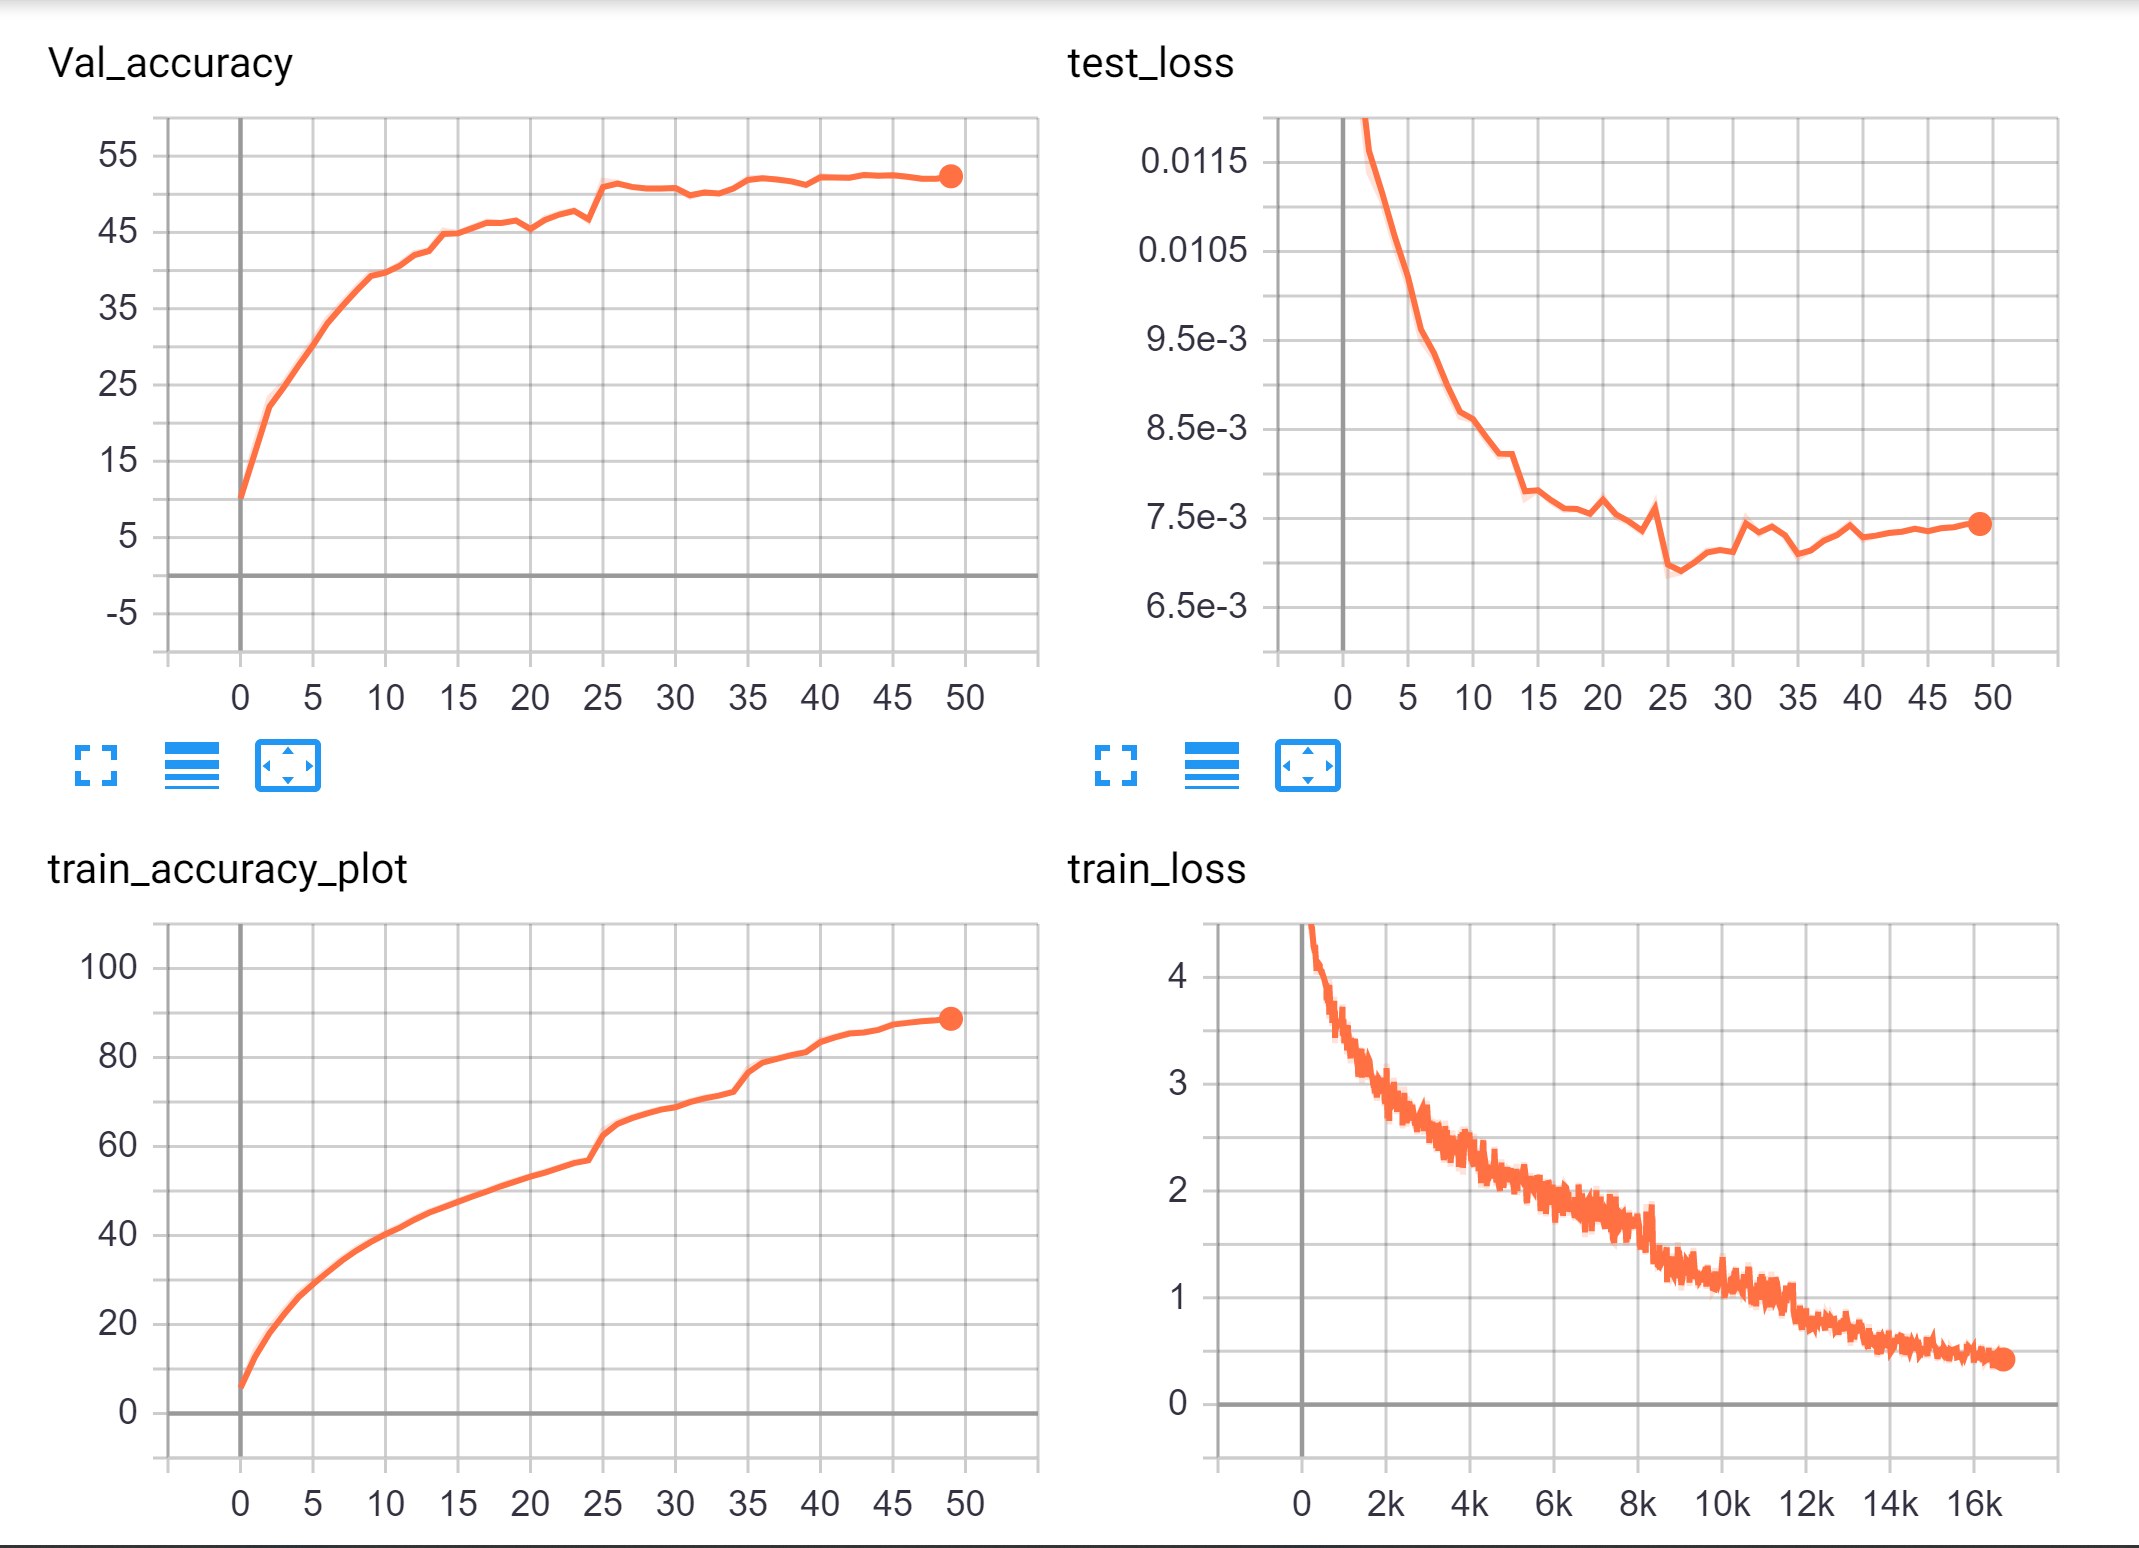

In [0]:
if  DO_TRAIN:
  %reload_ext tensorboard
  import os
  logs_base_dir = "./logs"
  os.makedirs(logs_base_dir, exist_ok=True)
  %tensorboard --logdir {logs_base_dir}

In [0]:
# defining a model and changing it accordint to the task
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = torchvision.models.densenet161()
model.classifier = torch.nn.Linear(2208,200)
model = model.to(device)

In [14]:
lr_rate = 1e-3
criterion = loss.CrossEntropyLoss()
epoches = 50
optimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay=2e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[25,35,40,45],gamma=0.5,)
exp_name = datetime.now().isoformat(timespec='seconds') + f'|densenet+weght_decay+lr_scheduler|lr_rate:{lr_rate}'
print(exp_name)

2020-05-20T08:19:28|densenet+weght_decay+lr_scheduler|lr_rate:0.001


In [15]:
!nvidia-smi

Wed May 20 08:19:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    57W / 149W |    426MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
if DO_TRAIN:
  train(epoches, model, criterion, optimizer, device, exp_name, train_dataloader, val_dataloader, scheduler=scheduler)

## Load and evaluate the model

In [47]:
# Your code here (load the model from "./checkpoint.pth")
# Please use `torch.load("checkpoint.pth", map_location='cpu')
# https://drive.google.com/file/d/14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ/view?usp=sharing

# Attention!!!!!!!!!!!!!!
# Dear evaluator, I have only  added a few lines of code(in this new submission file) here so that model (presaved) is downloaded from a drive when DO_TRAIN = False. 


if not DO_TRAIN:
    print('Downloading the model for a drive chekpoint')
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ" -O The_best_model.pth && rm -rf /tmp/cookies.txt
    model = torchvision.models.densenet161()
    model.classifier = torch.nn.Linear(2208,200)
    model.load_state_dict(torch.load('/content/The_best_model.pth', map_location='cpu'))
    model.eval();

elif DO_TRAIN:
    model = torchvision.models.densenet161()
    model.classifier = torch.nn.Linear(2208,200)
    model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/checkpoints/The_best_model.pth', map_location='cpu'))
    model.eval();


--2020-05-20 08:51:44--  https://docs.google.com/uc?export=download&confirm=fUPp&id=14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ
Resolving docs.google.com (docs.google.com)... 64.233.167.101, 64.233.167.139, 64.233.167.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.167.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-14-docs.googleusercontent.com/docs/securesc/4hdsqrdnva5e9cqikl7fnkq5uaffh5hl/4k94ljvu2pfcvkqc1q1lbqlg7r6qg4gn/1589964675000/01671260203005450161/14109717847229909717Z/14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ?e=download [following]
--2020-05-20 08:51:44--  https://doc-0s-14-docs.googleusercontent.com/docs/securesc/4hdsqrdnva5e9cqikl7fnkq5uaffh5hl/4k94ljvu2pfcvkqc1q1lbqlg7r6qg4gn/1589964675000/01671260203005450161/14109717847229909717Z/14JKV_cI-Z8eb1WD8tQs2r40hXjegxDIQ?e=download
Resolving doc-0s-14-docs.googleusercontent.com (doc-0s-14-docs.googleusercontent.com)... 108.177.15.132, 2a00:1450:400c:c0c::84
Connecting

In [48]:
## for some reason the inferece on cpu take a long time so also for inference i used gpu
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
path = Path.cwd()/'tiny-imagenet-200'
val_data = torchvision.datasets.ImageFolder(path/'val',transform = trans['test'])

val_dataloader = torch.utils.data.DataLoader(val_data,
                                         batch_size = 1000,
                                         num_workers = 4,
                                         shuffle=False,)

with torch.no_grad():
  correct=0
  model.to(device)
  for batch, labels in tqdm(val_dataloader): 
    batch, labels = batch.to(device), labels.to(device) 
    output = model(batch)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()

val_acc = 100*correct/len(val_dataloader.dataset)

In [49]:
val_accuracy = val_acc# Your code here
assert 0 <= val_accuracy <= 100
print("Validation accuracy: %.2f%%" % val_accuracy)

Validation accuracy: 54.98%


# Report

Below, please mention:

* A brief history of tweaks and improvements.
* Which network architectures have you tried? What is the final one and why?
* What is the training method (batch size, optimization algorithm, number of iterations, ...) and why?
* Which techniques have you tried to prevent overfitting? What were their effects? Which of them worked well?
* Any other insights you learned.

For example, start with:

"I have analyzed these and those conference papers/sources/blog posts. \
I tried this and that to adapt them to my problem. \
The conclusions this task taught me are ..."

- As I have tacked the Tiny-image-net challenge before I knew that Denset net works good for it. But I wanted to exepriment more, thus i have tried using AlexNet, Resnet18, Resnet50 and DensetNet161. Densenet worked better as it has skipp connection, that way is perserves spacial information better then other achitectures. Final achitectuers was Densenet161 as it had comparably good top errors considering its size.
-  For every model I noted the followig: They all overfit, expect AlexNet(did not manage to learn training set even). Thus taking something that really overfits and then tring to reduce this overfitting is a good wat to go in my experience. 
- I used two optimezer: Adama and SGD. SGD is quite slow in terms of convergence. Thus Adam was used. LR was set 1e-3 and over epoches was slowly reduced using learning scheduler for every 10 epoches with gamma 0.5. I used 50 epoches as in that case i got the best result.

- To tackle overfitting I used: Data Augmentation, Weight Decay and Varied batch size. The best worked data augmentation and weigh dacay. Bigger batch size gave slightly better results and thus i used batchsize of 300 samples. 

- Training a model for a comlex data set it not always fun thing as it seems from a first glance. Have patience, to make a **single change a time** over parameters. Use multiple colabs in parallel to not waste time. Have your own proviate GPU, better 2! Do not panic when you see overfitting, the chanses are you can reduce it quite well. Become one with the google - other dudes know more than you.  If you are allowed, fine tune pretrained model, that way you will save a hell of your nerves paul